In [1]:
import pandas as pd
import numpy as np
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import *
import xgboost as xgb
import matplotlib.pyplot as plt
import seaborn as sns
from ipynb.fs.full.Performance_Utilities import calculate_optimal_threshold, print_metrics
from utils.create_features_utils import *
from sklearn.base import clone
import os

In [2]:
tennis_file = "data/grass_matches_with_feature.csv"
raw_tennis_file = "data/mens/combined_raw_data.csv"
round_16_file = "data/wimbledon_2019.csv"

In [3]:
grass_tennis = pd.read_csv(tennis_file) # All grass court results from all years
list(grass_tennis.columns)
round_16 = pd.read_csv(round_16_file) # Round of 16 and on from Wimbledon 2019
raw_tennis = pd.read_csv(raw_tennis_file) # Raw tennis file

/opt/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3058: DtypeWarning: Columns (27,33) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [4]:
features_list = [
 'diff_rank',
 'diff_match_win_percent',
 'diff_games_win_percent',
 'diff_5_set_match_win_percent',
 'diff_close_sets_percent',
 'diff_match_win_percent_grass',
 'diff_games_win_percent_grass',
 'diff_5_set_match_win_percent_grass',
 'diff_close_sets_percent_grass',
 'diff_match_win_percent_52',
 'diff_games_win_percent_52',
 'diff_5_set_match_win_percent_52',
 'diff_close_sets_percent_52',
 'diff_match_win_percent_grass_60',
 'diff_games_win_percent_grass_60',
 'diff_5_set_match_win_percent_grass_60',
 'diff_close_sets_percent_grass_60',
 'diff_match_win_percent_hh',
 'diff_games_win_percent_hh',
 'diff_match_win_percent_grass_hh',
 'diff_games_win_percent_grass_hh']

In [5]:
grass_tennis = grass_tennis.dropna()

grass_tennis['diff_rank'] = grass_tennis['player_0_rank'] - grass_tennis['player_1_rank']

In [6]:
# Train-test split
y = grass_tennis.outcome
X = grass_tennis[features_list]

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, stratify=y, shuffle=True, test_size=0.20)

In [7]:
# Final to predict on
round_16['Date'] = '2019/07/07'
round_16['Surface'] = 'Grass'
round_16['diff_rank'] = round_16['player_0_rank'] - round_16['player_1_rank']

wimby_2019 = create_features(round_16, raw_tennis) # Round 16 and on Wimby 2019
X_wimby_2019 = wimby_2019[features_list]

Creating Player Career Stats All Surface
Creating Player Career Stats on Grass/Clay/Hard
Creating Player Career Stats All Surface Last 52 Weeks
Creating Player Career Stats on Grass/Clay/Hard Last 60 Weeks
Creating Player Head to Head Career Stats All Surface
Creating Player Head to Head Career Stats On Grass
Creating Difference Variables


In [8]:
wimby_2019.columns

Index(['Round', 'player_0', 'player_0_rank', 'player_1', 'player_1_rank',
       'Date', 'Surface', 'diff_rank', 'player_0_match_win_percent',
       'player_1_match_win_percent', 'player_0_games_win_percent',
       'player_1_games_win_percent', 'player_0_5_set_match_win_percent',
       'player_1_5_set_match_win_percent', 'player_0_close_sets_percent',
       'player_1_close_sets_percent', 'player_0_match_win_percent_grass',
       'player_1_match_win_percent_grass', 'player_0_games_win_percent_grass',
       'player_1_games_win_percent_grass',
       'player_0_5_set_match_win_percent_grass',
       'player_1_5_set_match_win_percent_grass',
       'player_0_close_sets_percent_grass',
       'player_1_close_sets_percent_grass', 'player_0_match_win_percent_52',
       'player_1_match_win_percent_52', 'player_0_games_win_percent_52',
       'player_1_games_win_percent_52', 'player_0_5_set_match_win_percent_52',
       'player_1_5_set_match_win_percent_52', 'player_0_close_sets_percent_5

In [9]:
# Random Forest
rfc = RandomForestClassifier(n_estimators=1100, max_depth = 3, random_state=19, n_jobs=-1)
rfc.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=3, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=1100,
                       n_jobs=-1, oob_score=False, random_state=19, verbose=0,
                       warm_start=False)

/opt/anaconda3/lib/python3.7/site-packages/pandas/core/series.py:1143: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#deprecate-loc-reindex-listlike
  return self.loc[key]


,Model,Accuracy,True Positive Rate,True Negative Rate,False Positive Rate,False Negative Rate,Sensitivity,Specificity,AUC,F1-Score,Geometric Mean,Kappa-Statistics,Sklearn Version
0,RF,0.695,0.228,0.941,0.059,0.772,0.228,0.941,0.683,0.341,0.463,0.201,0.22


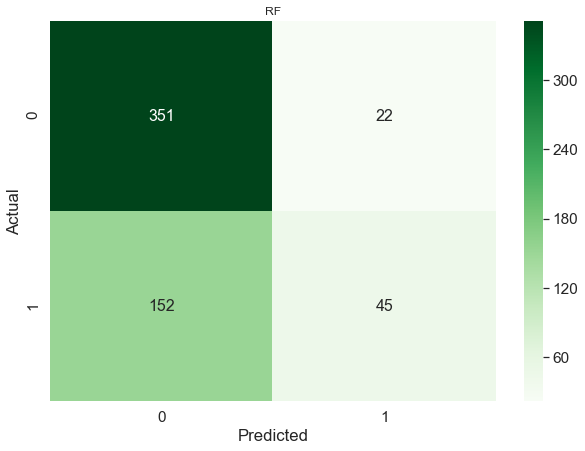

In [10]:
print_metrics(X_test, y_test, rfc, "RF")[1]

In [11]:
y_test_prob = rfc.predict_proba(X_wimby_2019)[:,1]
y_pred = rfc.predict(X_test)
y_test_prob

array([0.17505359, 0.46942139, 0.24979103, 0.20357895, 0.21037546,
       0.16992588, 0.19159245, 0.18765936, 0.18558587, 0.44819952,
       0.1889481 , 0.20396716, 0.20659686, 0.47083989, 0.46656297,
       0.47887158])

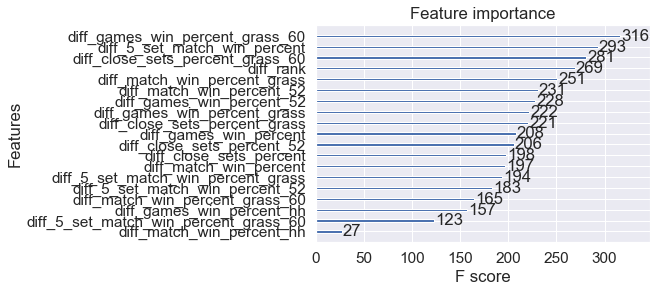

In [12]:
# XGBoost
os.environ['KMP_DUPLICATE_LIB_OK'] = 'True'
xgb_model = xgb.XGBClassifier(max_depth = 7, eta = .01, nthread=-1)
xgb_feat = xgb.plot_importance(xgb_model.fit(X_train, y_train), max_num_features=20)
plt.show()

/opt/anaconda3/lib/python3.7/site-packages/pandas/core/series.py:1143: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#deprecate-loc-reindex-listlike
  return self.loc[key]


,Model,Accuracy,True Positive Rate,True Negative Rate,False Positive Rate,False Negative Rate,Sensitivity,Specificity,AUC,F1-Score,Geometric Mean,Kappa-Statistics,Sklearn Version
0,XGB,0.665,0.34,0.836,0.164,0.66,0.34,0.836,0.634,0.412,0.533,0.192,0.22


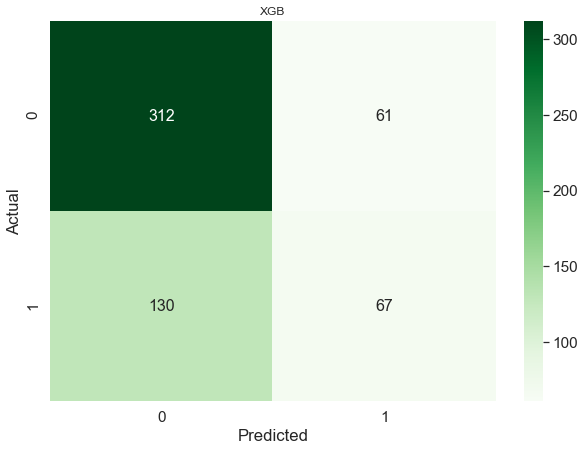

In [13]:
print_metrics(X_test, y_test, xgb_model, "XGB")[1]

In [14]:
xgb_model.predict_proba(X_wimby_2019)

array([[0.9560247 , 0.04397527],
       [0.2330563 , 0.7669437 ],
       [0.8222653 , 0.17773466],
       [0.8677493 , 0.13225073],
       [0.8218956 , 0.17810437],
       [0.9853141 , 0.01468595],
       [0.89760804, 0.10239193],
       [0.85005486, 0.14994511],
       [0.9112131 , 0.0887869 ],
       [0.5746422 , 0.42535785],
       [0.8212577 , 0.1787423 ],
       [0.9143285 , 0.08567151],
       [0.77290595, 0.22709407],
       [0.73154974, 0.2684503 ],
       [0.816465  , 0.18353498],
       [0.7881447 , 0.21185532]], dtype=float32)